<a href="https://colab.research.google.com/github/Joaogmr472/GLM/blob/main/C%C3%B3digo_4_Plota_GLM_e_IR_Livro_ELISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GOES-16: REDE GLM (PARTE IV)** 

**Plota Imagem do Infravermelho e GLM**

---

---
**OBJETIVO:** Este Google Colab ensina como plotar a imagem do canal infravermelho sobreposta com dados de relâmpagos do GLM de uma data específica.

**DADOS DE ENTRADA**: Dados de flashes do GOES-16 e Dados de Satélite. 

**Dados:** 

1.   **Dados do Sensor GLM:** Arquivos de relâmpagos a cada 5 min. **Local:** Os dados são processados e fornecidos pelo CPTEC/INPE e estão disponiveis [aqui](http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/), **Nome:** S11635949_202011010000.nc, **Formato:** Netcdf.

2.   **Dados do Sensor ABI:** Canal 13 - Infravermelho (10.8 µm) do sensor ABI a bordo do satélite GOES-16. **Local:** Os dados são processados e fornecidos pelo CPTEC/INPE e estão disponiveis [aqui](http://ftp.cptec.inpe.br//goes/goes16/retangular/ch13/), **Nome:** S10635346_202203010000.nc, **Formato:** Netcdf.
---

---
**DADOS DE SAÍDA:**
Mapa espacial de Relâmpagos Totais (IN + NS) acumulados em 10 minutos e temperatura de Brilho (°C)
---
**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:
1.   Instalação das bibliotecas de geração de mapas
2.   Importação das bibliotecas
3.   Monta o drive da pessoa
4.   Download dos dados através do servidor do CPTEC/INPE
5.   Plota a Figura 
---
**OBSERVAÇÕES IMPORTANTES**: 
1. Mudar o caminho para seu drive. Veja em: **###MUDANÇAS AQUI####**
---
***Realizado por: [João G M Ribeiro](https://github.com/Joaogmr472/) e [Enrique V Mattos](https://github.com/evmpython) - 29/mar/2022*** 
---


# **#########    MUDANÇAS AQUI    #########**

In [1]:
# Pasta para a Saída das Figuras
path_fig = f'/content/drive/MyDrive/JOAO_GABRIEL_MESTRADO/MESTRADO/DADOS/GLM/figuras/'

Escolhe a data para o plot da imagem

In [2]:
ano = '2022'
mes = '03'
dia = '06'
hor = '17'
minu = '30'

# **Instalando as bibliotecas**

In [3]:
# Instalando o cartopy (usado para gerar Mapas)
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install --no-binary shapely shapely --force
!pip install cartopy

# Instalando o proplot (usado para gerar Mapas também)
!pip install proplot==0.6.4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (72.6 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

# **Download de informações auxiliares**

In [4]:
# Criando os diretórios de entrada e saida
import os
os.makedirs('input', exist_ok=True)
os.makedirs('arquivos_auxiliares', exist_ok=True)

# Baixando os arquivos de shapefile dos estados brasileiros
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip -P /content/arquivos_auxiliares/ 
print('\n')

# Descomprimindo o arquivo de shapefile dos estados brasileiros
!unzip -o  /content/arquivos_auxiliares/br_unidades_da_federacao.zip -d /content/arquivos_auxiliares/
print('\n')

# Baixa paleta de cores
!wget -c https://www.dropbox.com/s/t7b8x2i3gnsq8gv/cpt_convert.py 
!wget -c https://www.dropbox.com/s/74vlk75bkh3fzaz/IR4AVHRR6.cpt

--2022-03-30 11:55:00--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10912177 (10M) [application/zip]
Saving to: ‘/content/arquivos_auxiliares/br_unidades_da_federacao.zip’

br_unidades_da_fede 100%[===================>]  10.41M  7.18MB/s    in 1.5s    

2022-03-30 11:55:03 (7.18 MB/s) - ‘/content/arquivos_auxiliares/br_unidades_da_federacao.zip’ saved [10912177/10912177]



Archive:  /content/arquivos_auxiliares/br_unidades_da_federacao.zip
 extracting: /content/arquivos_auxiliares/BR_UF_2019.cpg  
  inflating: /content/arquivos_auxiliares/BR_UF_2019.dbf  
  inflating: /content/arquivos_auxiliares/BR_UF_2019.prj  
  inflating: /content/arquivos_auxiliares/BR_UF_2019.shp  
  infl

# **Importa as bibliotecas**

In [5]:
import pandas as pd
import xarray as xr
import numpy as np
import proplot as plot
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import os
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from datetime import datetime, timedelta
from google.colab import drive
drive.mount('/content/drive')
import matplotlib
matplotlib.rcParams.update({'font.size':22})
from matplotlib import pyplot as plt
from cpt_convert import loadCPT # Importando a função CPT convert 
from matplotlib.colors import LinearSegmentedColormap # interpolação linear para as cores dos mapas

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/proplot/config.py:1454: ProPlotWarning: Rebuilding font cache.


Mounted at /content/drive


# **Importa funções**

In [6]:
#----------------------------------------------------------------------------------- 
# Função que plota os Estados 
#----------------------------------------------------------------------------------- 
def evm_plot_states():
    shapefile = list(shpreader.Reader('/content/arquivos_auxiliares/BR_UF_2019.shp').geometries())
    ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=1.0)   

# **PROCESSAMENTO DOS DADOS:** Nesta etapa serão utilizados os dados de **relâmpagos** do sensor GLM e **temperatura de brilho** do canal infravermelho do sensor ABI, ambos pertencentes ao satélite GOES-16. Serão produzidas as seguintes figuras:

1.   **Mapa espacial** da temperatua do canal infravermelho do satélite e relâmpagos do satélite GOES-16.

## **Baixando os dados do sensor ABI:**

In [7]:
# Endereço do FTP do CPTEC-INPE
ftp_cptec = 'ftp.cptec.inpe.br'

# ---------------------------------------------------------- #
#              BAIXANDO DOS DO ABI
# ---------------------------------------------------------- #
# Nome do arquivo
file_ir =  f'{ftp_cptec}/goes/goes16/retangular/ch13/{ano}/{mes}/S10635346_{ano}{mes}{dia}{hor}{minu}.nc'

# Download dos arquivos
!wget -c {file_ir} -P /content/input/

--2022-03-30 11:55:33--  http://ftp.cptec.inpe.br/goes/goes16/retangular/ch13/2022/03/S10635346_202203061730.nc
Resolving ftp.cptec.inpe.br (ftp.cptec.inpe.br)... 150.163.141.22
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.141.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13712497 (13M) [application/x-netcdf]
Saving to: ‘/content/input/S10635346_202203061730.nc’

S10635346_202203061 100%[===================>]  13.08M   822KB/s    in 34s     

2022-03-30 11:56:09 (391 KB/s) - ‘/content/input/S10635346_202203061730.nc’ saved [13712497/13712497]



## **Baixando os dados do sensor GLM:**

In [8]:
# ---------------------------------------------------------- #
#              BAIXANDO DOS DO GLM 
# ---------------------------------------------------------- #
# S11635949_202009010000.nc	
path_glm = '/goes/goes16/goes16_web/glm_acumulado_nc/' ; path_total = f'{ftp_cptec}{path_glm}'

# primeiro arquivo: 5min
#basename_glm_5min = f'S11635949_{ano}{mes}{dia}{hor}{minu}.nc'

# segundo arquivo: 10min
date_10min = str(datetime(int(ano), int(mes), int(dia), int(hor), int(minu)) + timedelta(minutes=5)) # calcula a imagem + 5min
ano_10min = datetime.strptime(date_10min, '%Y-%m-%d %H:%M:%S').strftime('%Y')  # extrai o ano 
mes_10min = datetime.strptime(date_10min, '%Y-%m-%d %H:%M:%S').strftime('%m')  # extrai o mes 
dia_10min = datetime.strptime(date_10min, '%Y-%m-%d %H:%M:%S').strftime('%d')  # extrai o dia 
hor_10min = datetime.strptime(date_10min, '%Y-%m-%d %H:%M:%S').strftime('%H')  # extrai o hora 
minu_10min = datetime.strptime(date_10min, '%Y-%m-%d %H:%M:%S').strftime('%M') # extrai o minuto
basename_glm_10min = f'S11635949_{ano_10min}{mes_10min}{dia_10min}{hor_10min}{minu_10min}.nc'

 # path + nome dos arquivos
#file_glm_5min = f'{path_total}{ano}/{mes}/{basename_glm_5min}'
file_glm_10min = f'{path_total}{ano_10min}/{mes}/{basename_glm_10min}'

# Download dos arquivos
#!wget -c {file_glm_5min} -P /content/input/
!wget -c {file_glm_10min} -P /content/input/

--2022-03-30 11:56:09--  http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/2022/03/S11635949_202203061735.nc
Resolving ftp.cptec.inpe.br (ftp.cptec.inpe.br)... 150.163.141.22
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.141.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 246563 (241K) [application/x-netcdf]
Saving to: ‘/content/input/S11635949_202203061735.nc’

S11635949_202203061 100%[===================>] 240.78K   281KB/s    in 0.9s    

2022-03-30 11:56:11 (281 KB/s) - ‘/content/input/S11635949_202203061735.nc’ saved [246563/246563]



# **Plotando o mapa espacial: CH13 + GLM Flashes** 


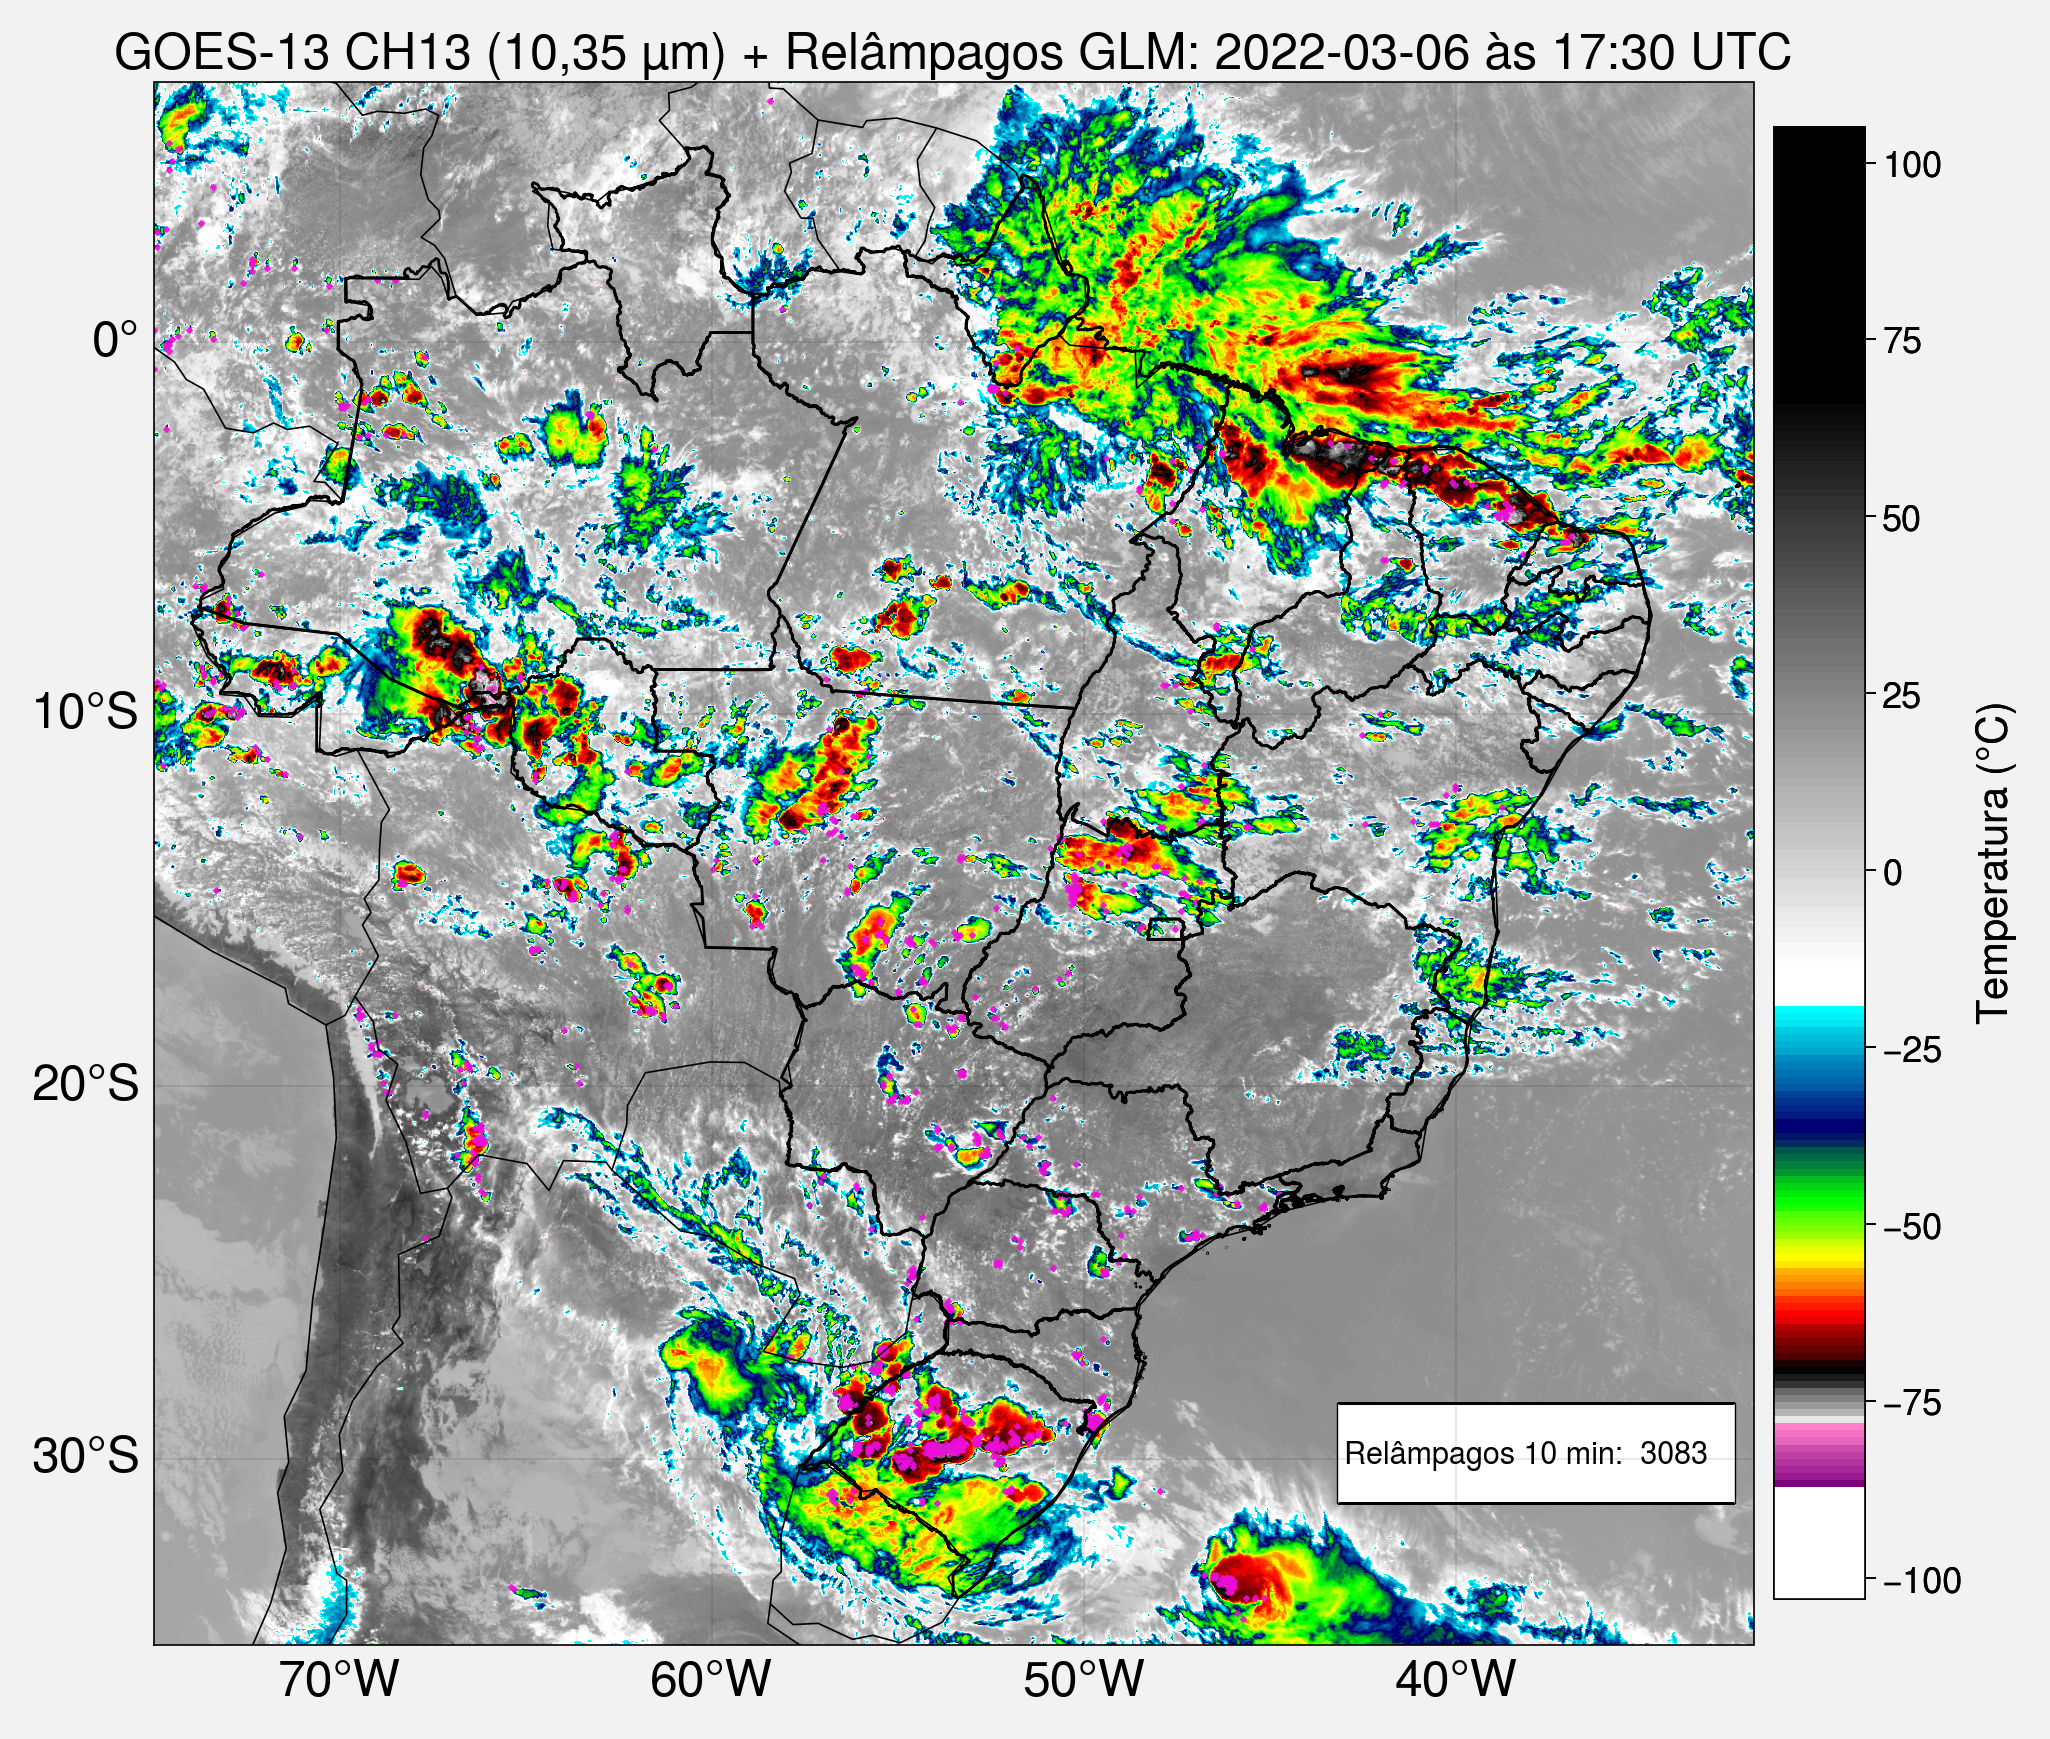

In [11]:

basename = os.path.basename(os.path.splitext(file_ir)[0]) 
file = f'/content/input/{basename}.nc'

# Leitura do arquivo
imagem = xr.open_dataset(file)

# Extrai os limites das latitudes e longitudes
latmin, latmax, lonmin, lonmax = float(imagem['lat'][0]), float(imagem['lat'][-1]), float(imagem['lon'][0]), float(imagem['lon'][-1])
# lats/lons do quadrado limitando o Brasil
latmin1, latmax1, lonmin1, lonmax1 = -35, 7, -75, -32

# Divide por 100 e transforma para Celsius
imagem = (imagem['Band1']/100.)-273.15

# Inverte a matriz
imagem = np.flipud(imagem)

# Plotando a figura
fig, ax = plot.subplots(axwidth=8, axheight=8, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=True, borders=True, innerborders=False, labels=True, latlines=10, lonlines=10,
          latlim=(latmin1,latmax1), lonlim=(lonmin1,lonmax1), fontsize=11, 
          title=f'GOES-13 CH13 (10,35 µm) + Relâmpagos GLM: {ano}-{mes}-{dia} às {hor}:{minu} UTC', small='25px', large='25px')



# Carrega tabela de cores do Infravermelho
cpt_ir = loadCPT('/content/IR4AVHRR6.cpt'); cpt_convert_ir = LinearSegmentedColormap('cpt_ir', cpt_ir)
# limites da paleta de cores
vmin_ir = -103.0 
vmax_ir = 105   

# Plota a variável: Infravermelho
map1 = ax.imshow(imagem, vmin=vmin_ir, vmax=vmax_ir, cmap=cpt_convert_ir, extent=[lonmin, lonmax, latmin, latmax],
                 levels=plot.arange(vmin_ir, vmax_ir, 1.0))

#---------------------------------------------#
#              plota flashes GLM
#---------------------------------------------#
# 5 min
'''
glm_5min = xr.open_dataset(f'/content/input/{basename_glm_5min}')
df = glm_5min.to_dataframe().reset_index().dropna()
ax.scatter(df['lon'].values, df['lat'].values, transform=ccrs.PlateCarree(), marker='x', s=5, color='b')    

flash5 = df['flash'].sum()
ax.text(-68.,-31.5, f'Flash 5min:   {flash5}', color = 'b', va="top", fontsize = 11)
'''

patches_m = []
midwest = np.array([[-43.2,-28.5],[-43.2,-31.2],[-32.5,-31.2],[-32.5,-28.5]])
patches_m.append(Polygon(midwest))
ax.add_collection(PatchCollection(patches_m, facecolor='white', edgecolor='black', linewidths=0.5))

# 10 min
glm_10min = xr.open_dataset(f'/content/input/{basename_glm_10min}')
df = glm_10min.to_dataframe().reset_index().dropna()
ax.scatter(df['lon'].values, df['lat'].values, transform=ccrs.PlateCarree(), marker="x",alpha=0.9,s=2, color='fuchsia')  

flash10 = df['flash'].sum()
#flash10 = '{:f}'.format(flash10)
flash10 = int(flash10)
ax.text(-43.,-29.5, f'Relâmpagos 10 min:  {flash10}', color = 'k', va="top", fontsize = 11)

# plota contornos dos Estados
evm_plot_states()

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Temperatura ($\degree$C)', ticks=25, ticklabelsize=13, labelsize=15, space=0.1, length=0.92)

# salva figura
fig.save(f'{path_fig}Fig4_goes16_glm_ch13_{ano}{mes}{dia}_{hor}{minu}.jpg', dpi=300, bbox_inches='tight')

# exibe a figura na tela
plot.show() 